# Steps
1. Make data choice.
5. Choose 'fixed' configuration.
6. For each 'fixed' configuration, optimize the other parameters based on RMSE.
7. Given optimal setting, run popularity bias analysis for every version of the 'fixed' configuration.

## Libraries

In [1]:
%env MKL_THREADING_LAYER=tbb
%env OPENBLAS_NUM_THREADS=24
%env NUMBA_NUM_THREADS=96
%env MKL_NUM_THREADS=96
%env OMP_NUM_THREADS=1

env: MKL_THREADING_LAYER=tbb
env: OPENBLAS_NUM_THREADS=24
env: NUMBA_NUM_THREADS=96
env: MKL_NUM_THREADS=96
env: OMP_NUM_THREADS=1


In [2]:
import os
os.environ["MKL_THREADING_LAYER"] = "tbb"
os.environ["OPENBLAS_NUM_THREADS"] = '24'
os.environ["NUMBA_NUM_THREADS"] = '96'
os.environ["MKL_NUM_THREADS"] = '96'
os.environ["OMP_NUM_THREADS"] = '1'
# for random generation
import numpy as np 
import random as rd


# basic functions
import pandas as pd
pd.options.display.max_rows = 100
import pickle
import scipy.io


# custom-made functions
import modelling_mf
from optimize_hp import optimize_lkpy, optimize_cornac

# lenskit RS library
from lenskit.algorithms import user_knn


# cornac RS library
from cornac.models import UserKNN

## Data and parameters

In [3]:
data="epinion"
mat = scipy.io.loadmat("data/"+data+"_events.mat")
mat_df = pd.DataFrame(mat['rating_with_timestamp'])
mat_df.columns = ['user', 'item', '.', 'rating', '..', '...']
epinion_ratings = mat_df[['user','item','rating']]

In [4]:
data="ml1m"
# user-item interactions
ml1m_ratings = pd.read_csv("data/"+data+"_events.dat", header=None, sep='::', engine='python').drop(3, axis=1)
ml1m_ratings.columns = ['user', 'item', 'rating']

In [5]:
data="fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("data/"+data+"_events.csv")

Make data choice.

In [6]:
ratings = ml1m_ratings.copy()
ratings = ratings.drop_duplicates(subset = ['user','item'], keep = 'last')
data_strategy = 'ml1m'

In [7]:
user_col = "user" # the name of the column that includes the users
item_col = "item" # the name of the column that includes the items
predict_col="rating" # the name of the column that includes the interaction

In [8]:
evaluation_way = "cross_validation"
verbose = False
plot = True
save_plot = True # save the plots
fallback = False
nr_recs = 10
sampling_strategy = "frac"
partition_way = "user"

## Optimize, train, evaluate LKPY
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [9]:
algo_versions = {"UserKNN":[{'min_nbrs':1, 'min_sim':0},
                            {'min_nbrs':2, 'min_sim':0},
                            {'min_nbrs':10, 'min_sim':0},
                            {'min_nbrs':1, 'min_sim':-1},
                            {'min_nbrs':2, 'min_sim':-1},
                            {'min_nbrs':10, 'min_sim':-1}
                           ]}

{'min_nbrs': 1, 'min_sim': 0}
We got them already
nr of longtail 11802
9.769867549668874
nr of longtail 11766
9.740066225165563
nr of longtail 11797
9.790041493775934
nr of longtail 11800
9.7682119205298
nr of longtail 11715
9.697847682119205


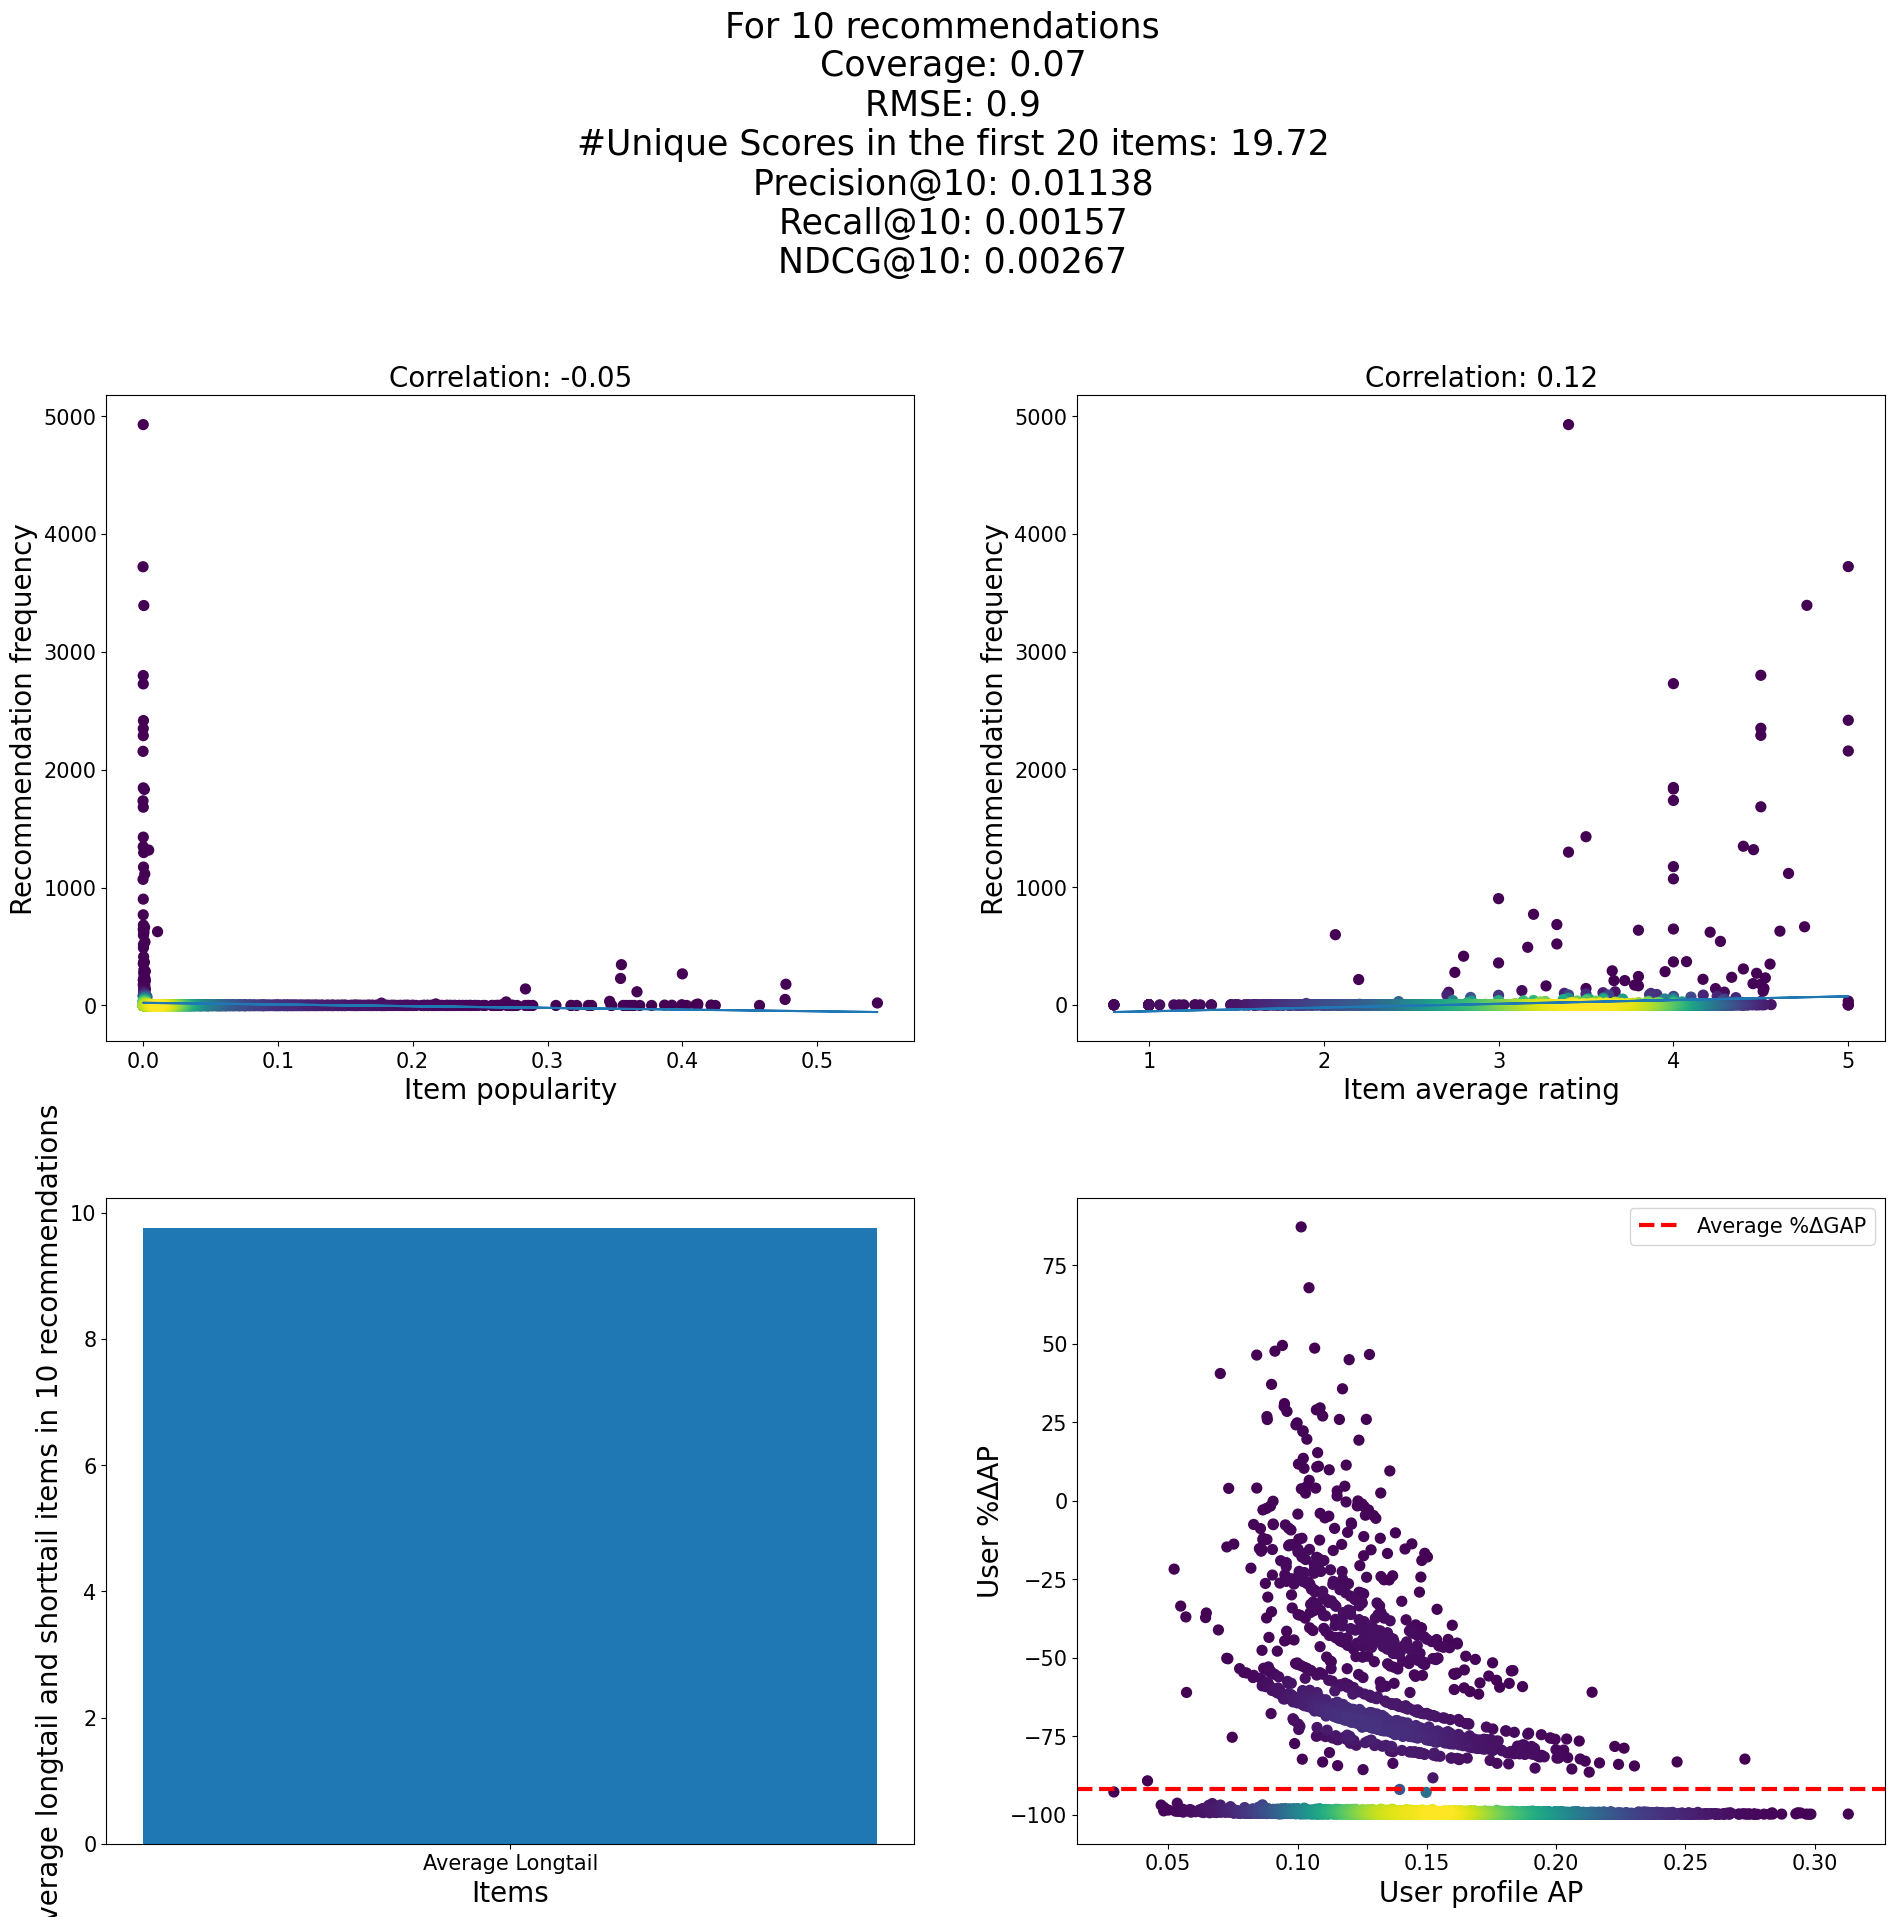

{'min_nbrs': 2, 'min_sim': 0}
We got them already
nr of longtail 10668
8.831125827814569
nr of longtail 10407
8.615066225165563
nr of longtail 10588
8.786721991701246
nr of longtail 10696
8.85430463576159
nr of longtail 10489
8.68294701986755


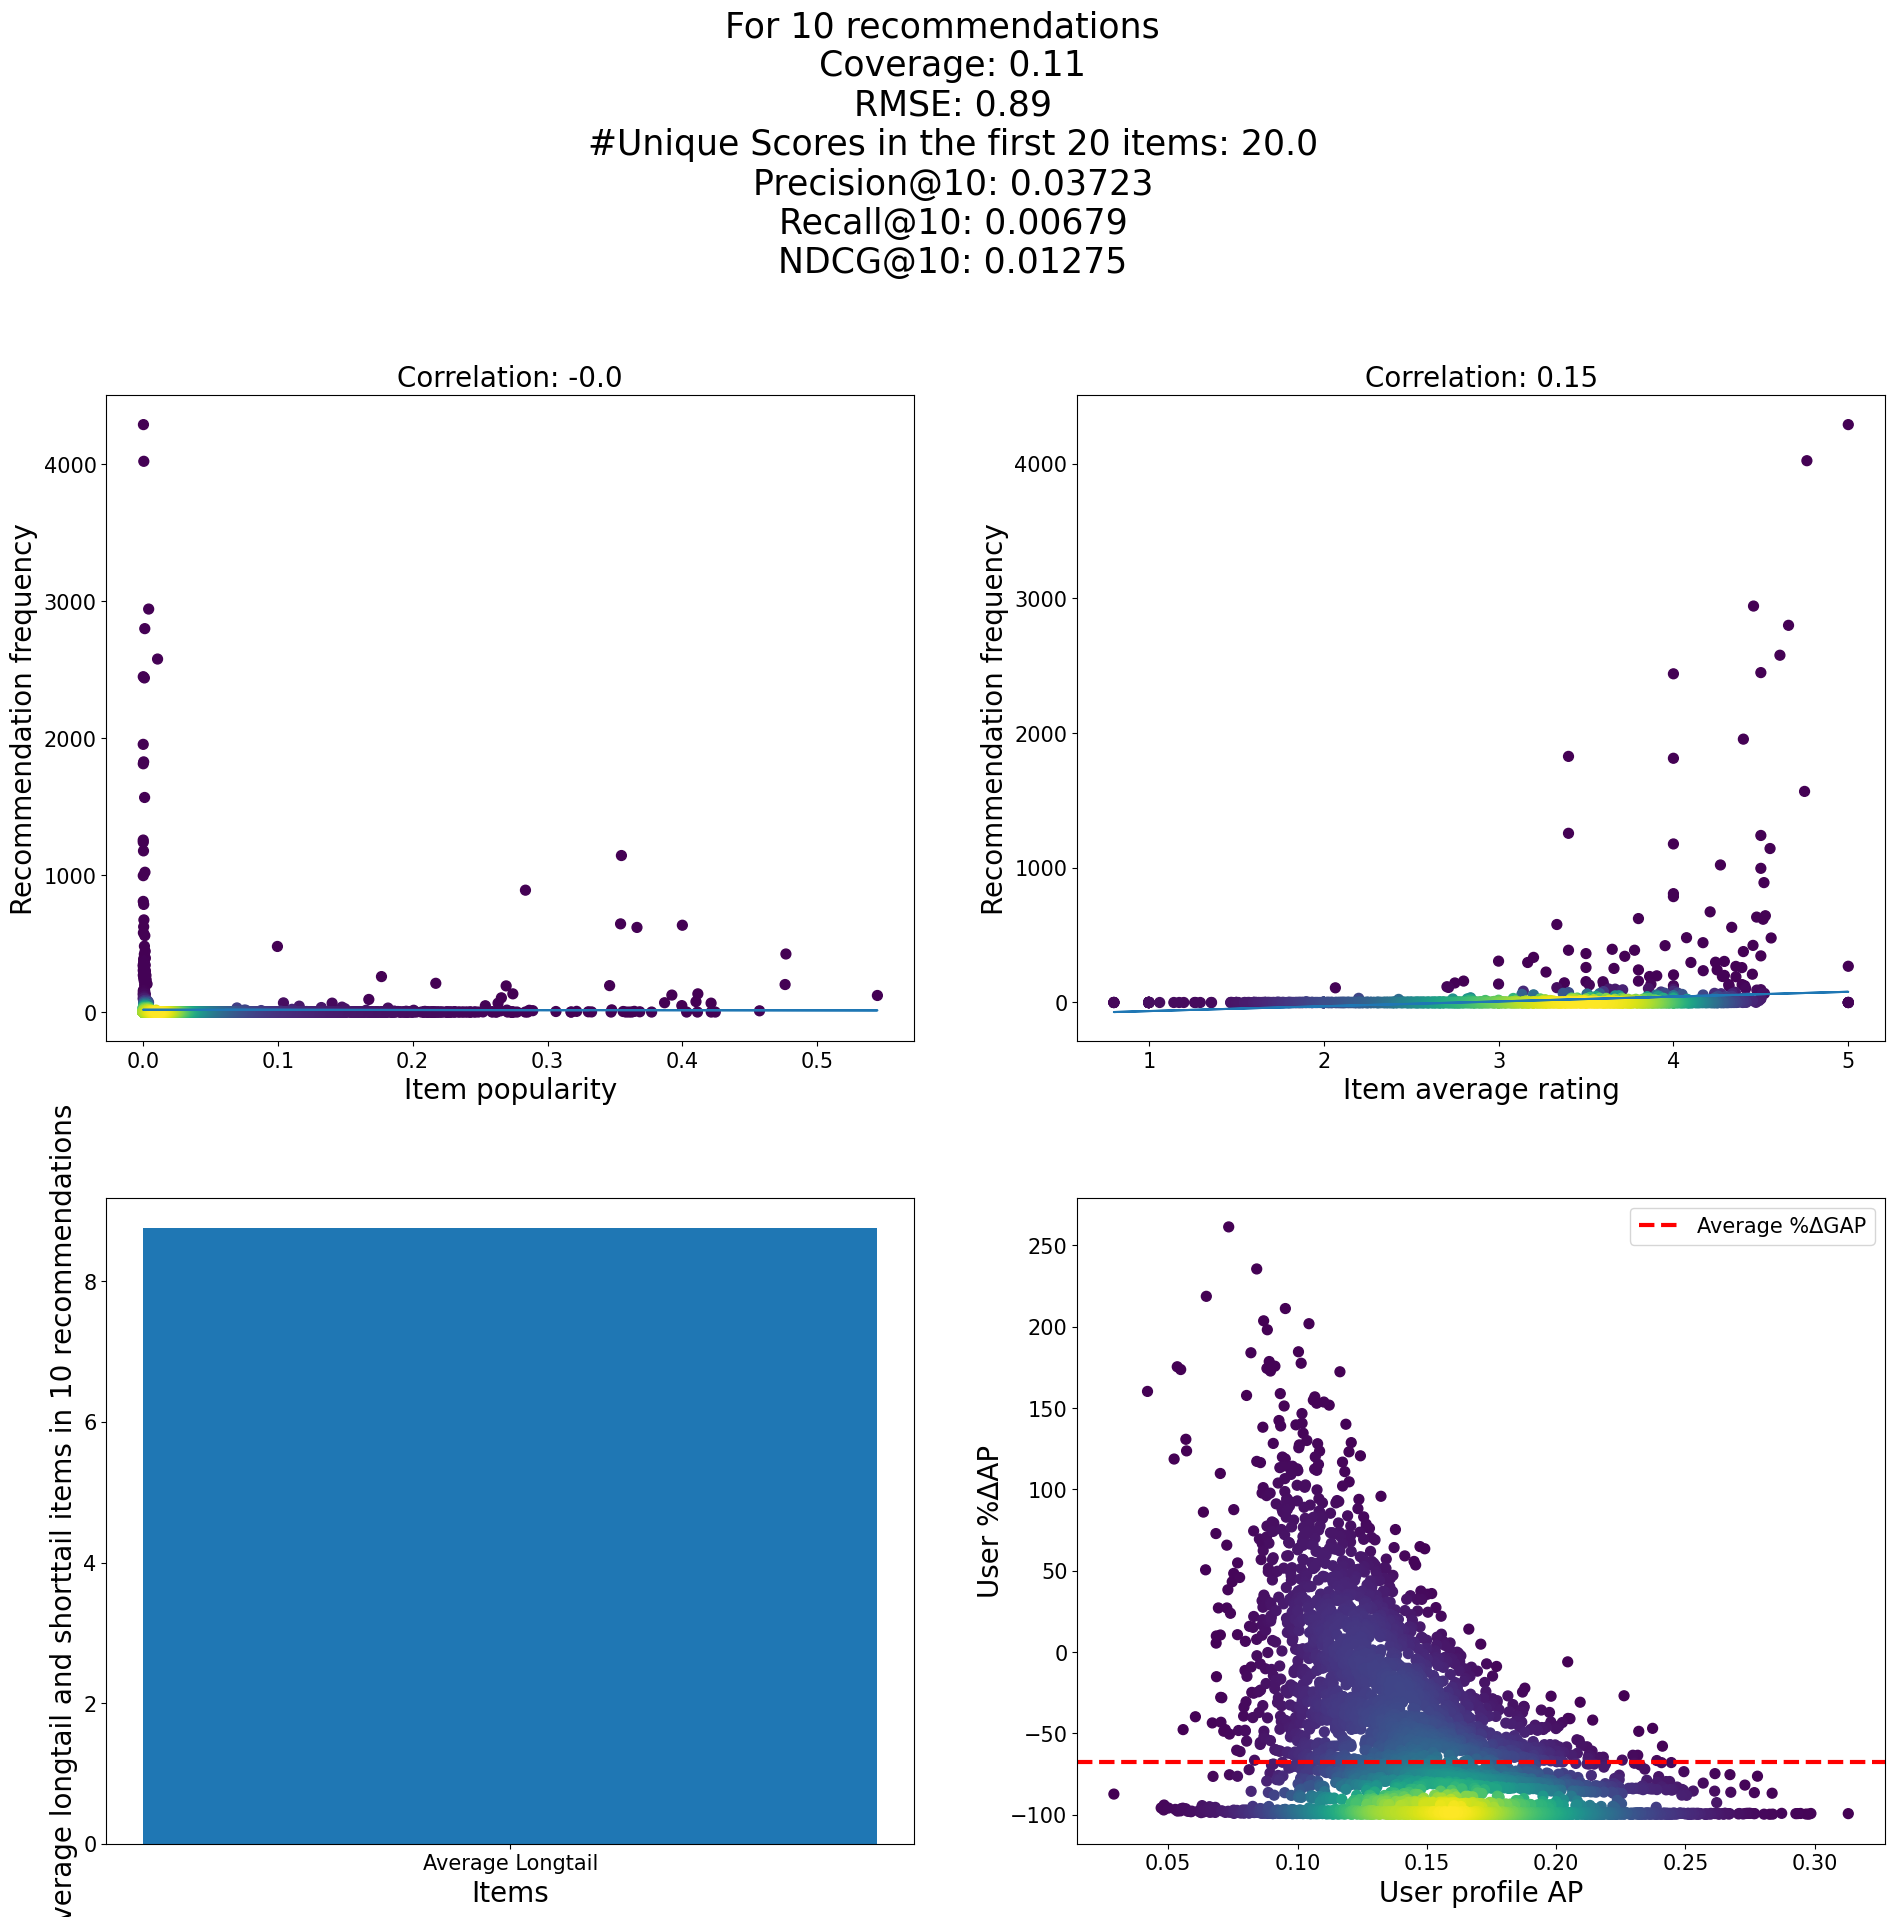

{'min_nbrs': 10, 'min_sim': 0}
We got them already
nr of longtail 4005
3.3153973509933774
nr of longtail 4014
3.3228476821192054
nr of longtail 4054
3.3643153526970955
nr of longtail 4227
3.4991721854304636


In [ ]:
# choose algorithm
algorithm_lkpy = user_knn.UserUser
algo_name = "UserKNN"
versions = algo_versions[algo_name]

# for every 'fixed' version of the algorithm
for args in versions:
    print(args)

    p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
    if os.path.isfile(p):
        print("We got them already")
        with open(p, "rb") as f:
            best_params = pickle.load(f)
    else:
        print("We have to compute them now")
        # optimize for this fixed version
        best_params = optimize_lkpy(
            ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20, partition_way = 'row'
        )

        # save the best parameters for this fixed version

        with open(
            "best_parameters/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(best_params, f)

    
    # # optimize for this fixed version
    # best_params = optimize_lkpy(ratings=ratings, algorithm_name=algo_name, args=args, partition_way='row', max_evals=20)

    # # save the best parameters for this fixed version

    # with open('best_parameters/'+algo_name+'/'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
    #     pickle.dump(best_params, f)


    optimal_nnbrs = best_params["nnbrs"]
    

    # run the training and evaluation for the fixed version + the best other parameters
    pop_biases_lkpy, metrics_dict_lkpy, GAP_vs_GAP_lkpy = modelling_mf.train_algorithm(algorithm = lambda: algorithm_lkpy(nnbrs=optimal_nnbrs,
                                                            
                                                            center=True,
                                                            min_sim=args['min_sim'],
                                                            min_nbrs=args['min_nbrs']),
                                                    algo_name = algo_name,  
                                                    ratings = ratings,
                                                    evaluation_way = evaluation_way,
                                                    verbose = verbose, 
                                                    n=nr_recs,
                                                    sampling_strategy = sampling_strategy,
                                                    partition_way = partition_way,
                                                    plot = plot,
                                                data_strategy=data_strategy,
                                                args=args,
                                                save_plot=save_plot)

   
    # Save metrics!
    with open('experimental_results/'+algo_name+'/'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
        pickle.dump(metrics_dict_lkpy, f)
    with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
        pickle.dump(pop_biases_lkpy, f)
    with open('experimental_results/'+algo_name+'/correct_detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
        pickle.dump(GAP_vs_GAP_lkpy, f)

## Optimize, train, evaluate Cornac
- **Algorithm**
- **Fixed parameters**
- **To-optimize parameters**

In [ ]:
mapping_dict = {} # Create a dictionary that maps each item to an integer - necessary for Cornac.
i=0
for mov in ratings[item_col].unique():
    mapping_dict[mov] = i
    i+=1
ratings[item_col] = ratings[item_col].map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

In [ ]:
algo_versions = {"CornacUserKNN":[{'center':True}],
                }

In [ ]:
algorithm_cornac = UserKNN
algo_name = "CornacUserKNN"
versions = algo_versions[algo_name]

for args in versions:
    print(data_strategy, args)


    p = "best_parameters/" + algo_name + "/" + data_strategy + "_" + str(args) + ".pkl"
    if os.path.isfile(p):
        print("We got them already")
        with open(p, "rb") as f:
            best_params = pickle.load(f)
    else:
        print("We have to compute them now")
        # optimize for this fixed version
        best_params = optimize_cornac(
            ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20
        )

        # save the best parameters for this fixed version

        with open(
            "best_parameters/"
            + algo_name
            + "/"
            + data_strategy
            + "_"
            + str(args)
            + ".pkl",
            "wb",
        ) as f:
            pickle.dump(best_params, f)
    
    # # optimize for this fixed version
    # best_params = optimize_cornac(ratings=ratings, algorithm_name=algo_name, args=args, max_evals=20)

    # # save the best parameters for this fixed version

    # with open('best_parameters/'+algo_name+'/'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
    #     pickle.dump(best_params, f)


    optimal_k = best_params['k']

    

    pop_biases_cornac, metrics_dict_cornac, GAP_vs_GAP_cornac = modelling_mf.train_algorithm_cornac(algorithm = lambda: algorithm_cornac(k=optimal_k,
                                                                                                             mean_centered=args['center']),
                                                    algo_name = algo_name,  
                                                    ratings = ratings,
                                                    evaluation_way = evaluation_way,
                                                    verbose = verbose, 
                                                    n=nr_recs,
                                                    sampling_strategy = sampling_strategy,
                                                    partition_way = partition_way,
                                                    plot = plot,
                                                data_strategy=data_strategy,
                                                args=args,
                                                save_plot=save_plot)

    # Save metrics!
    with open('experimental_results/'+algo_name+'/'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
        pickle.dump(metrics_dict_cornac, f)
    with open('experimental_results/'+algo_name+'/detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
        pickle.dump(pop_biases_cornac, f)
    with open('experimental_results/'+algo_name+'/correct_detailed_per_item_'+data_strategy+'_'+str(args)+'.pkl', 'wb') as f:
        pickle.dump(GAP_vs_GAP_cornac, f)